# Figure 3 Data

This folder contains data for figure 3 of our article. They include data from one of the computational models of glass formers (Poly-(12,0) glass former).
- "gis_poly12.txt": inherent-state shear modulus data.
- "nuis_poly12.txt": inherent-state Poisson's ratio data.

In [1]:
import numpy as np
from scipy.special import iv 
from scipy.integrate import solve_ivp

#The RG flow equations
def flow(t,x):
    Kinvr = 0.25*(np.pi**2*x[1]**2)*np.exp(1/(8*np.pi*x[0]))*(2*iv(0,1/(8*np.pi*x[0]))-iv(1,1/(8*np.pi*x[0])))
    yr = (2-1/(8*np.pi*x[0]))*x[1]+2*(np.pi*x[1]**2)*np.exp(1/(16*np.pi*x[0]))*iv(0,1/(8*np.pi*x[0]))
    Ginvr = (np.pi**2*x[1]**2)*np.exp(1/(8*np.pi*x[0]))*(iv(0,1/(8*np.pi*x[0])))#-iv(1,1/(8*np.pi*x[0])))
    #b = (2-1/(8*np.pi*x[0]))*x[1]
    return np.array([Kinvr,yr,Ginvr])

def fug(T,G,Ypsq,nu):
    Ec = 0.25*(nu+3)/(nu+1)*G*(np.pi*Rexc**2)*ec**2+Ypsq/(8*np.pi)
    return np.exp(-Ec/T)

We use the RG flow equations to determine the KT transition temperature for a given model. See our article and supplemental material for theoretical basis behind the calculations. The RG flow equations are solved using a Python solver. 

The input to our calculation is inherent-state elastic moduli of a given glass former. 

In [2]:
#For loop for integrating RG flow equations and determining the transition temperature
listofnames = ['poly12']
utilde = [0.116]
sigmam = [1.1]
To = [0.25]

for i in range(len(listofnames)):
    print(listofnames[i]) 
    
    #Load IS shear modulus data
    data = np.loadtxt('gis_{}.txt'.format(listofnames[i]))[:,:]
    index = np.argsort(data[:,0])
    data = data[index[::-1]]
    data = data[::-1]
    
    #Load IS Poisson's ratio data
    data1 = np.loadtxt('nuis_{}.txt'.format(listofnames[i]))[:,:]
    index = np.argsort(data1[:,0])
    data1 = data1[index[::-1]]
    data1 = data1[::-1]
    
    length = min(len(data),len(data1))
    data = data[:length]
    data1 = data1[:length]
    
    #For Poly-(12,0)
    G = data[:,1]
    nu = data1[:,1]
    u = utilde[i]
    sigma = sigmam[i]
    ec = 2*np.sqrt(2)*u*(1+u)/(1+2*u)
    Rexc = 0.5*np.sqrt(3)*sigma/(1+2*u)
    p = 2*np.pi*Rexc*ec/(1+nu)
    Ypsq = 2*G*(1+nu)*p**2
    Gpsq = G*p**2
    
    #We go through the first for loop, using individual temperature datapoint.
    K = []
    Grenorm = []
    temp = []
    scale = []
    max_t = 100
    dt = 1e-4
    t = np.linspace(0,max_t,int(max_t/dt))
    for j in range(len(data)):
        y0 = np.array([data[j,0]/Ypsq[j],fug(data[j,0],G[j],Ypsq[j],nu[j]),data[j,0]/Gpsq[j]])
        sol = solve_ivp(fun=flow,t_span=(0,max_t),y0=y0,t_eval=t,method='BDF')
        if sol.y[0,-1] > 1e-4:
            temp.append(data[j,0])
            K.append(sol.y[0,-1])
            Grenorm.append(sol.y[2,-1])
        index = np.argmin(np.abs(sol.y[0,:]-sol.y[0,-1]-1e-3))
        scale.append(sol.t[index])
    K = np.array(K)
    Grenorm = np.array(Grenorm)
    if min(np.abs(K-16*np.pi)) < 1e-6:
        print(K[index],temp[index])
    else:
        print("Insufficient accuracy. T_KT is higher than highest temperature data")
        
        #Empirically, the KT transition can be found at temperatures higher than the highest temperature datapoint. 
        #Since the elastic moduli typically reach a plateau value at higher temperatures, we can take the highest-T datapoint
        #and use the elastic moduli value for all higher temperatures and refine the search for the transition temperature.
        
        #Set an initial min and max temperature to search on
        mintemp = max(data[:,0])*0.5
        maxtemp = max(data[:,0])*2
        Tkt = 0
        for j in range(10):
            K = []
            Grenorm = []
            temp = []
            Temp = np.linspace(mintemp,maxtemp,10)
            for j in range(len(Temp)):
                y0 = np.array([Temp[j]/Ypsq[-1],fug(Temp[j],G[-1],Ypsq[-1],nu[-1]),Temp[j]/Gpsq[-1]])
                sol = solve_ivp(fun=flow,t_span=(0,max_t),y0=y0,t_eval=t)#,method='DOP853')
                if sol.y[0,-1] > 1e-4:
                    temp.append(Temp[j])
                    K.append(sol.y[0,-1])
                    Grenorm.append(sol.y[2,-1])
            K = np.array(K)
            Grenorm = np.array(Grenorm)
            index = np.argmin(np.abs(K-16*np.pi))
            print(K[index]-16*np.pi,temp[index])
            
            #Refine the search for the transition by making the search interval smaller
            try:
                mintemp = np.copy(temp[index-1])
            except:
                mintemp = np.copy(temp[index])*0.95
            try:
                maxtemp = np.copy(temp[index+1])
            except:
                maxtemp = np.copy(temp[index])*1.05
            Tkt = temp[index]
            print(Tkt)

poly12
Insufficient accuracy. T_KT is higher than highest temperature data
-50.25126924528651 0.25
0.25
-50.24926256292244 0.26388888888888884
0.26388888888888884
-50.246646890341175 0.27109053497942387
0.27109053497942387
-50.24625555059043 0.2713191586648377
0.2713191586648377
-50.24609236778568 0.27136996392826296
0.27136996392826296
-50.24518976581246 0.27142641422095776
0.27142641422095776
-50.24406032256228 0.27142892312285527
0.27142892312285527
-50.22392205979374 0.2714305957241203
0.2714305957241203
-49.503780539570215 0.2714309674132903
0.2714309674132903
-47.36205026874051 0.2714309949458214
0.2714309949458214


We can perform the RG calculation again, to plot the elastic moduli as a function of temperature.

In [3]:
#For loop for integrating RG flow equations and determining the transition temperature
listofnames = ['poly12']
utilde = [0.116]
sigmam = [1.1]
To = [0.25]

for i in range(len(listofnames)):
    print(listofnames[i]) 
    
    #Load IS shear modulus data
    data = np.loadtxt('gis_{}.txt'.format(listofnames[i]))[:,:]
    index = np.argsort(data[:,0])
    data = data[index[::-1]]
    data = data[::-1]
    data = np.vstack((np.append(data[:,0],np.linspace(0.25,0.28,100)),np.append(data[:,1],np.ones(100)*data[-1,1]))).T
    #print(data[:,0])
    #Load IS Poisson's ratio data
    data1 = np.loadtxt('nuis_{}.txt'.format(listofnames[i]))[:,:]
    index = np.argsort(data1[:,0])
    data1 = data1[index[::-1]]
    data1 = data1[::-1]
    data1 = np.vstack((np.append(data1[:,0],np.linspace(0.25,0.28,100)),np.append(data1[:,1],np.ones(100)*data1[-1,1]))).T
    
    length = min(len(data),len(data1))
    data = data[:length]
    data1 = data1[:length]
    
    #For Poly-(12,0)
    G = data[:,1]
    nu = data1[:,1]
    u = utilde[i]
    sigma = sigmam[i]
    ec = 2*np.sqrt(2)*u*(1+u)/(1+2*u)
    Rexc = 0.5*np.sqrt(3)*sigma/(1+2*u)
    p = 2*np.pi*Rexc*ec/(1+nu)
    Ypsq = 2*G*(1+nu)*p**2
    Gpsq = G*p**2
    
    #We go through the first for loop, using individual temperature datapoint.
    K = []
    Grenorm = []
    temp = []
    scale = []
    max_t = 100.0
    dt = 1e-4
    t = np.linspace(0,max_t,int(max_t/dt))
    for j in range(len(data)):
        y0 = np.array([data[j,0]/Ypsq[j],fug(data[j,0],G[j],Ypsq[j],nu[j]),data[j,0]/Gpsq[j]])
        sol = solve_ivp(fun=flow,t_span=(0,max_t),y0=y0,t_eval=t,method='BDF')
        #if sol.y[0,-1] > 1e-4:
        temp.append(data[j,0])
        K.append(1/sol.y[0,-1])
        Grenorm.append(1/sol.y[2,-1])
        index = np.argmin(np.abs(sol.y[0,:]-sol.y[0,-1]-1e-3))
        scale.append(sol.t[index])
    K = np.array(K)
    Grenorm = np.array(Grenorm)

poly12


Plotting the shear modulus as a funciton of temperature

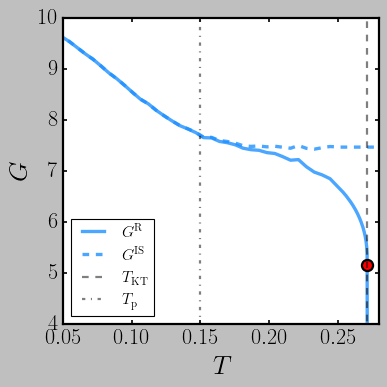

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
mpl.rcParams['text.usetex'] = True

def lin(x,a,b):
    return a*x+b

def red():
    return '#d65858'
def blue():
    return '#1E90FF'
def black():
    return '#000000'
def orange():
    return '#FF8C00'
def brown():
    return '#A52A2A'
def darkorchid():
    return '#9932CC'
def darkgreen():
    return '#006400'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# fig, ax1 = plt.subplots(figsize=(5.5,6))
G_RG = Grenorm*np.array(temp)/p**2#(1/Grenorm)*np.array(temp)#data[:,0]#/p**2#np.loadtxt('grenorm_poly12.txt')
b_RG = 1/np.array(temp)#data[:,0]#1/G_RG[:,0]
#G_RG = G_RG[:,1]
b_data = 1/data[:,0]
Gis = data[:,1]

fig, ax1 = plt.subplots(figsize=(5,5))

plot_G_RG = plt.plot(1./b_RG[:-1],G_RG[:-1])
plot_G_is = plt.plot(1/b_data,Gis)#np.append(1./b_data[4:],np.linspace(0.27,0.28,100)),np.append(Gis[4:],np.ones(100)*Gis[-1]))

plt.setp(plot_G_is, 'linewidth', 3, 'color', blue(), linestyle='--',marker='o', markersize=0, alpha=0.8,label="$G^\mathrm{IS}$")

plt.plot(0.271,5.15,'o',markersize=10,markeredgewidth=2)

plt.setp(plot_G_RG, 'linewidth', 3, 'color', blue(), linestyle='-',marker='o', markersize=0, alpha=0.8,label="$G^\mathrm{R}$")

plot_zero = plt.plot([.271,.271],[0,10])

plt.setp(plot_zero, 'linewidth', 2, 'color', black(), linestyle='--',marker='o', markersize=0, alpha=0.5,label="$T_\mathrm{KT}$")

plot_zero = plt.plot([.15,.15],[0,10])

plt.setp(plot_zero, 'linewidth', 2, 'color', black(), linestyle='-.',marker='o', markersize=0, alpha=0.5,label="$T_\mathrm{p}$")

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.0)
ax.tick_params(axis='x', direction='in')
ax.tick_params(axis='y', direction='in')
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)
# Change the size of the fontsize
axfontsize = 20

for tick in ax1.xaxis.get_major_ticks():
      tick.label1.set_fontsize(axfontsize)
for tick in ax1.yaxis.get_major_ticks():
      tick.label1.set_fontsize(axfontsize)

# for tick in ax1.get_xticklabels():
#       tick.set_fontname("Arial")
# for tick in ax1.get_yticklabels():
#       tick.set_fontname("Arial")

every_nth_y = 1
for n, label in enumerate(ax1.yaxis.get_ticklabels()):
    if (n) % every_nth_y != 0:
        label.set_visible(False)

every_nth_x = 1
for n, label in enumerate(ax1.xaxis.get_ticklabels()):
    if (n) % every_nth_x != 0:
        label.set_visible(False)

# ax1.set_xticklabels([])

plt.xlim([0.05,0.28])
plt.ylim([4.0,10])
plt.ylabel("$G$",fontsize=24)
plt.xlabel("$T$",fontsize=24)
plt.legend(loc='lower left')
# ax1.set_xscale('log')
# ax1.set_yscale('log')

plt.tight_layout()
#fig.savefig('G_shear_modulus_RG_1.pdf', dpi=300)
plt.show()

Plotting the dimensionless Young's modulus as a function of inverse temperature

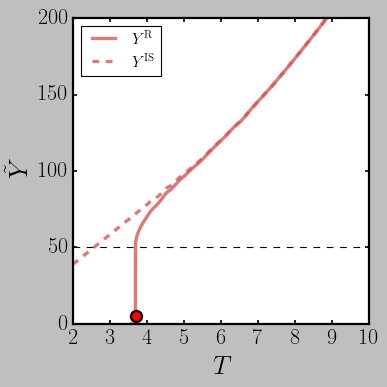

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
mpl.rcParams['text.usetex'] = True

def lin(x,a,b):
    return a*x+b

def red():
    return '#d65858'
def blue():
    return '#1E90FF'
def black():
    return '#000000'
def orange():
    return '#FF8C00'
def brown():
    return '#A52A2A'
def darkorchid():
    return '#9932CC'
def darkgreen():
    return '#006400'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# fig, ax1 = plt.subplots(figsize=(5.5,6))
Y_RG = K
b_RG = 1/np.array(temp)
b_data = 1/data[:,0]
Yis = Ypsq*b_data

fig, ax1 = plt.subplots(figsize=(5,5))

plot_G_RG = plt.plot(b_RG[:-1],Y_RG[:-1])
plot_G_is = plt.plot(np.append(b_data[4:],np.linspace(1/0.27,1/100.0,100)),np.append(Yis[4:],np.ones(100)*Ypsq[-1]*np.linspace(1/0.27,1/100.0,100)))

plt.setp(plot_G_is, 'linewidth', 3, 'color', red(), linestyle='--',marker='o', markersize=0, alpha=0.8,label="$Y^\mathrm{IS}$")

plt.plot(1/0.271,5.15,'o',markersize=10,markeredgewidth=2)

plt.setp(plot_G_RG, 'linewidth', 3, 'color', red(), linestyle='-',marker='o', markersize=0, alpha=0.8,label="$Y^\mathrm{R}$")

plt.plot(np.linspace(2,10,25),np.ones(25)*16*np.pi,'k--')

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.0)
ax.tick_params(axis='x', direction='in')
ax.tick_params(axis='y', direction='in')
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)
# Change the size of the fontsize
axfontsize = 20

for tick in ax1.xaxis.get_major_ticks():
      tick.label1.set_fontsize(axfontsize)
for tick in ax1.yaxis.get_major_ticks():
      tick.label1.set_fontsize(axfontsize)

# for tick in ax1.get_xticklabels():
#       tick.set_fontname("Arial")
# for tick in ax1.get_yticklabels():
#       tick.set_fontname("Arial")

every_nth_y = 1
for n, label in enumerate(ax1.yaxis.get_ticklabels()):
    if (n) % every_nth_y != 0:
        label.set_visible(False)

every_nth_x = 1
for n, label in enumerate(ax1.xaxis.get_ticklabels()):
    if (n) % every_nth_x != 0:
        label.set_visible(False)

# ax1.set_xticklabels([])

plt.xlim([2,10.0])
plt.ylim([0.0,200])
plt.ylabel(r"$\tilde{Y}$",fontsize=24)
plt.xlabel("$T$",fontsize=24)
plt.legend(loc='upper left')
# ax1.set_xscale('log')
# ax1.set_yscale('log')

plt.tight_layout()
#fig.savefig('G_shear_modulus_RG_1.pdf', dpi=300)
plt.show()